# LIB

In [1]:
# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import Basic_Generator, Full_Diff_Generator, Pic_Generator, Max_Pic_Generator, Has_Pic_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch
from CST import CST

data_folder=  'Data3'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)

seed=0
batch_size=32
np.random.seed(seed)

def identity(x):
    return(x)

def Log(x): 
    return(np.log(1 - x + 0.1))

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# PREPROSS

In [2]:
D=[Load_FLX_dict('DictPrepross2.hdf5')]
#del(D[0].dict['qi'])
#del(D[0].dict['ql'])
#del(D[0].dict['ri'])
#del(D[0].dict['rl'])

In [3]:
Klist0 = []
Klist = []

D2 = [DictPrepross(['o3','pl','q'], 
     [Level_Normalizer(False), Level_Normalizer(False), Level_Normalizer(False)] )]

fit_genator = Has_Pic_Generator(folder=data_folder, batch_size=10*batch_size, chosen_var=['flxd', 'flxu'],
                                  train=True, preprocess_x=D+Klist0, custom_b_p_e=0)
fit_genator.max_b=50
D2[0].fitonGen(fit_genator, axis=2)
del(fit_genator)

In [4]:
# V

V = [VarSuppression(['fcld', 'ri', 'rl'])]
##### Full Preprocessing :
FP = D + Klist + D2 + V

##### b_size
np.random.seed(0)
train_generator =  Has_Pic_Generator(folder=data_folder, batch_size=batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'])

validation_generator = Has_Pic_Generator(folder='Data', batch_size=batch_size, train=False, 
                                             preprocess_x=FP, chosen_var=['flxd', 'flxu'])
validation_generator.max_b = 500

header_x = train_generator.used_variables
header_y = train_generator.true_variables_pred

in_channel=len(header_x)
o_channel = len(header_y)
lev=72

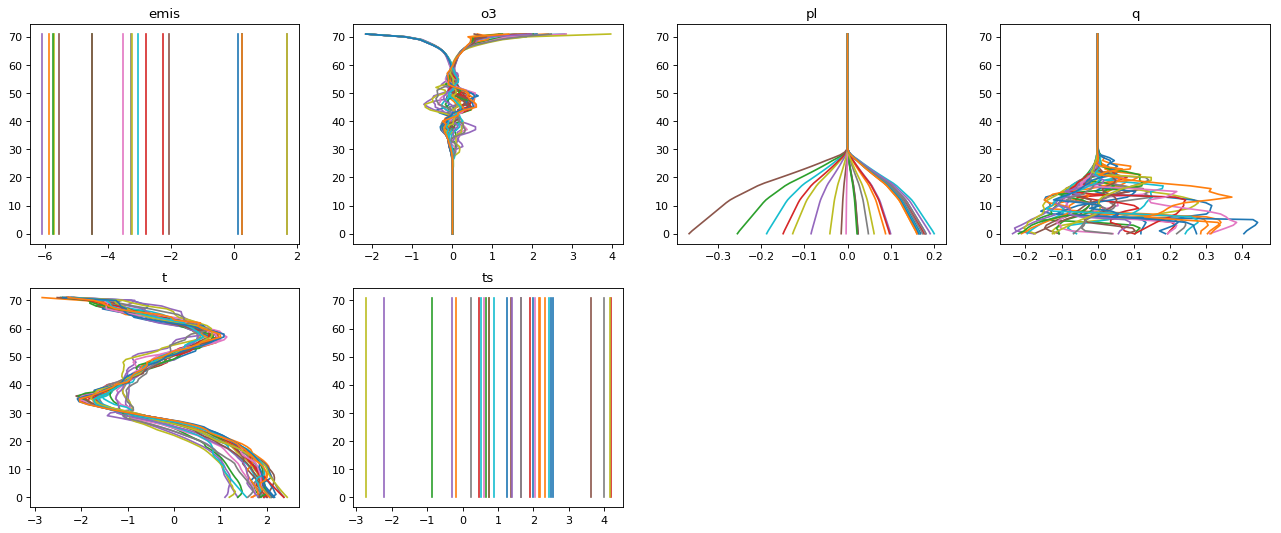

In [5]:
x,y = train_generator[500]
Plot_Batch(x, header_x)

In [6]:
#A = Pic_Generator(folder='Data', batch_size=batch_size, train=False, preprocess_x=FP, chosen_var=['flxd', 'flxu'])
#_,y2 = A[0]
#y2.shape

In [7]:
import keras
import tensorflow as tf
from architectures import AE, Unet_Act_Double, Contraction, Bidir_Casual_Conv
from architectures_simples import Upsampler, Divide_Recombine
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log, Name
from keras.layers import Dense, Flatten, Reshape, Lambda, Input, Activation

import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime

lev=72

list_of_filters_bd =  [[48, 64,  128], 
                       [48, 64,  128], 
                       [192]]

list_of_kernel_bd =  [[10, 5, 5], 
                      [10, 5, 5],
                      [8]]

list_of_activation_bd =  [['relu', 'relu','relu'], 
                          ['relu','relu','relu'],
                          ['relu']]

list_of_filters_ae =  [[192, 256],
                         [192, 192, 128, 128, 100, 100], 
                         [100, 110]]

list_of_kernel_ae =  [[10, 10],
                        [2, 5, 2, 5, 2, 4], 
                        []]

list_of_activation_ae =  [['relu', 'relu'], 
                             ['relu', 'relu', 'relu', 'relu', 'relu', 'relu'],
                             ['relu', 'relu', 'relu']]

params_ae = [0.01]
reg = 1e-6

M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_bd = Bidir_Casual_Conv(list_of_kernel_bd, list_of_filters_bd, list_of_activation_bd, 
                         lev=CST.lev(CST), in_channel=in_channel, params=params_ae, reg=reg)

M_unet =  Contraction(list_of_kernel_ae, list_of_filters_ae, list_of_activation_ae,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=192, reg=reg)
#M_f = Divide_Recombine(2, list_of_filters_ae[-1][-1], lev=lev)

M = keras.models.Sequential()
M.add(M_Up); M.layers[-1].name = 'Upsampler'
M.add(M_bd); M.layers[-1].name = 'Bd'
M.add(Dropout(0.01, noise_shape=(1, 192 )))
M.add(M_unet); M.layers[-1].name = 'Unet'
#M.add(Dropout(0.01))
#M.add(Dense(100, activation='relu'))
M.add(Dense(1, activation='sigmoid'))

#M.add(Activation('sigmoid'))

# Reshape to make a one hot of shape (bs, 2, 1) 
L_0 = lambda X : keras.layers.Concatenate(axis=-1)([X, 1-X])
L_1 = lambda X : tf.expand_dims(X, axis=-1)

L1 = keras.layers.Lambda(L_0)
L2 = keras.layers.Lambda(L_1)
#M.add(L1)
#M.add(L2)
#AG = Activation_Generator()
#M.add(AG('softmax', 'sf')); 

#M.layers[-1].name = 'Div_Rec'
M.summary()
#M.load_weights('SavedModels/Best_AE')

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures_simples.py:29: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", strides=5)`
  Avg = AveragePooling1D(pooling, padding='same', stride=avg)(Up)
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:188: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_100", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:188: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_101", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:188: UserWarning: Update your `Av

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsampler (Model)            (None, 72, 6)             0         
_________________________________________________________________
Bd (Model)                   (None, 72, 192)           512288    
_________________________________________________________________
dropout_1 (Dropout)          (None, 72, 192)           0         
_________________________________________________________________
Unet (Model)                 (None, 990)               3043186   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 991       
Total params: 3,556,465
Trainable params: 3,556,465
Non-trainable params: 0
_________________________________________________________________


In [8]:
#M.load_weights('TrainedModels/20190618130652Semi_Unet')

In [8]:
import tensorflow as tf
from keras.utils import np_utils

def LogLoss(y_true, y_pred, coef=[1, 100, 10]):
    # Convertion
    y0 = tf.cast(y_true[:,:,-1], dtype=tf.int32)
    y0 = tf.one_hot(y0, depth=2,axis=-1)    
    y1 = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    # Cross Loss
    L =- y0[:,:,0]*K.log(y1[:,:,0]+0.000001)*coef[0]
    L -= y0[:,:,1]*K.log(y1[:,:,1]+0.000001)*coef[1]
    
    L = coef[2]*K.sum(L, axis=1)
    return(L)

def LogLoss_one_hot(y_true, y_pred, coef=[20, 1, 10]):
    # Convertion
#    print(y_true.shape, y_pred.shape)
    y0 = tf.cast(y_true, dtype=tf.int32)
    y0 = K.max(y0, axis=-1)
    y0 = 1 - tf.one_hot(y0, depth=1,axis=-1)    
    y1 = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    L =- y0[:,0]*K.log(y1[:,0]+0.000001)*coef[0]
    L -= (1-y0[:,0])*K.log(  (1-y1[:,0])+0.000001)*coef[1]
    L = tf.expand_dims(L, axis=1)
    L = coef[2]*L#K.sum(L, axis=1)
    return(L)


def Accuracy(y_true, y_pred):
    pred = tf.less(-y_pred, -0.5)
    pred = tf.cast(pred ,tf.float32)
    Ac1 = pred[:,0]*y_true[:,0]
    Ac2 = (1-pred[:,0])*(1-y_true[:,0])
    return (Ac1+Ac2)

def Precision(y_true, y_pred):
#    print(y_pred)
    pred = tf.less(-y_pred, -0.5)
    pred = tf.cast(pred ,tf.float32)
    TP = (pred[:,0]*y_true[:,0])*32
#    print(K.get_value(pred[:,0]))
    Ac1 = TP / tf.cast(K.sum(pred[:,0])+0.0001, tf.float32) 
#    if(K.get_value(K.max(pred[:,0]))==0):
#        pass 
    return Ac1

def Pics(y_true, y_pred):
    return(y_true[:,0])

x,y = train_generator[0]
y0 = M.predict(x)
K.get_value(LogLoss_one_hot(y,y0))
a=K.get_value(Accuracy(y,y0))
p=K.get_value(Precision(y,y0))

In [9]:
class Prec():
    def __init__(self):
        self.n = 0
        self.avg_prec = 0
        self.avg_recall = tf.zeros((32,1))
        self.true_avg_recall = tf.zeros((32,1))
    
    def recall(self,y_true, y_pred):
        pred = tf.less(-y_pred, -0.5)
        pred = tf.cast(pred ,tf.float32)
        if( K.max(pred[:,0])==0):
            self.avg_recall = self.true_avg_recall
        else:
            TP = (pred[:,0]*y_true[:,0])*32
            Ac1 = TP / tf.cast(K.sum(pred[:,0])+0.0001, tf.float32)
            Ac1 = tf.expand_dims(Ac1, axis=-1)
            self.avg_recall = Ac1
            self.true_avg_recall = self.true_avg_recall*self.n/(self.n+1) + Ac1/(self.n+1)
            self.n+=1
        return(self.avg_recall)

x,y = train_generator[0]
y0 = M.predict(x)
y[0]=1
prec = Prec()  
Lbd_recall = lambda y,y1 : prec.recall(y,y1)

In [10]:
from keras import optimizers
from keras.losses import mean_squared_error
from architectures_utils import LossHistory, Generate_Log
import datetime
import keras_metrics

ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, restore_best_weights=True)
prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
archi = 'Semi_Unet'

LH = LossHistory(frequency=train_generator.batch_per_file, losses=['loss'])
Adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-7, amsgrad=False)
M.compile(loss = LogLoss_one_hot, optimizer=Adam, metrics=[LogLoss_one_hot, keras_metrics.precision(), keras_metrics.recall()])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsampler (Model)            (None, 72, 6)             0         
_________________________________________________________________
Bd (Model)                   (None, 72, 192)           512288    
_________________________________________________________________
dropout_1 (Dropout)          (None, 72, 192)           0         
_________________________________________________________________
Unet (Model)                 (None, 990)               3043186   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 991       
Total params: 3,556,465
Trainable params: 3,556,465
Non-trainable params: 0
_________________________________________________________________


In [11]:
validation_generator.max_b=0
history = M.fit_generator(train_generator, validation_data=validation_generator, callbacks=[ES, LH], verbose=1, shuffle=False, epochs=10)

Epoch 1/10
6972/7265 [===========================>..] - ETA: 11s - loss: 11.1776 - LogLoss_one_hot: 11.0775 - precision: 0.0979 - recall: 0.6989

KeyboardInterrupt: 

In [11]:
y0=M.predict(x)
y0.T

array([[0.1036795 , 0.88605696, 0.68042064, 0.08516658, 0.3108505 ,
        0.39764565, 0.2686844 , 0.24998379, 0.9257185 , 0.27967414,
        0.00157943, 0.5963251 , 0.06536401, 0.29141012, 0.29177594,
        0.08282351, 0.25299728, 0.25593293, 0.25694793, 0.2412729 ,
        0.30214417, 0.0614664 , 0.23788132, 0.2526208 , 0.1638685 ,
        0.4026379 , 0.52993387, 0.45209926, 0.00637959, 0.54911935,
        0.2022024 , 0.50956815]], dtype=float32)

In [13]:
# IMPORTANT MODEL LOG SAVER

file = os.path.join(log_folder, prefix+archi+'.txt')
M.save_weights(os.path.join(model_folder, prefix+archi))
with open(file, 'w') as f:
    with redirect_stdout(f):
        print('Seed {}'.format(seed))
        print('Optimizer')
        print(Adam.get_config())
        print('Prepross')
        for P in FP:
            print(P)
        M.summary
        for i, model in enumerate(M.layers):
            if( str(type(model)) == '<class \'keras.engine.training.Model\'>'):
                model.summary()
#        for k in history.history.keys():
#            print(k,':', history.history[k])
        print('\n')
        print('Unet')
        print('list_of_filters_unet = ',list_of_filters_ae)
        print('list_of_kernel_unet = ',list_of_kernel_ae)
        print('list_of_activation_unet = ', list_of_activation_ae)
#        for loss in LH.losses:
#            print(loss)
#            print(LH.losses[loss])

# TEST

In [82]:
# This validation generator is a Pic_Generator so we can see the output
validation_generator2 = Pic_Generator(folder='Data', batch_size=batch_size, train=False, 
                                             preprocess_x=FP, chosen_var=['flxd', 'flxu'])

In [ ]:
TP = 0
T = 0

for i, (x,y) in enumerate(validation_generator2):
    y0 = M.predict(x)
    pred = (y0>0.5).astype(int).T
    y_truth = np.max(y[:,:,-1], axis=-1).reshape(-1,1)
    TP+= (pred.flatten()*y_truth.flatten())
    if(i>100):
        break

In [125]:
from utils import F_and_plots, Plot_diff
j=np.random.randint(len(validation_generator2))
print(j)
x,y = validation_generator2[j]

y_truth = np.max(y[:,:,-1], axis=-1).reshape(-1,1)
y0 = M.predict(x)

1047


In [126]:
a = Accuracy(y_truth,y0); 
print(np.mean(K.get_value(a)))
p = Precision(y_truth, y0)
print(np.mean(K.get_value(p)), np.max(y_truth))

0.84375
0.399992 1.0


In [127]:
print(y_truth.T[0].astype(int))
print(pred[0])
print(K.get_value(tf.cast(Accuracy(y0,y_truth), tf.int32)))

[1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [128]:
pred = (y0>0.5).astype(int).T
correct = (pred.flatten()*y_truth.flatten()) + (1 - pred.flatten())*(1-y_truth.flatten())
fp = (pred.flatten()*(1-y_truth.flatten()))
tn = (1-pred.flatten())*(1-y_truth.flatten())

In [129]:
fp

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

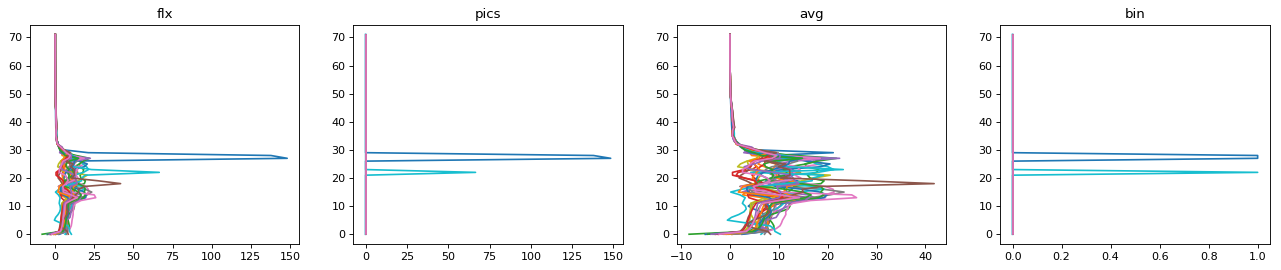

In [130]:
Plot_Batch(y[np.where(correct==1)[0]], ['flx', 'pics', 'avg', 'bin'] )

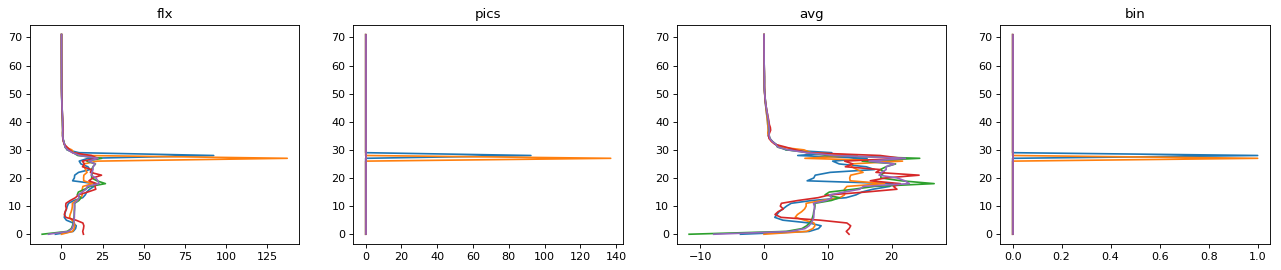

In [131]:
Plot_Batch(y[np.where(correct==0)[0]], ['flx', 'pics', 'avg', 'bin'] )

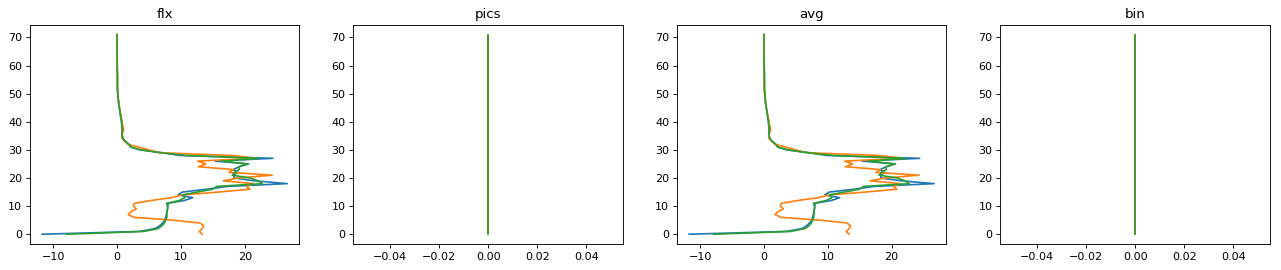

In [132]:
Plot_Batch(y[np.where(fp==1)[0]], ['flx', 'pics', 'avg', 'bin'] )

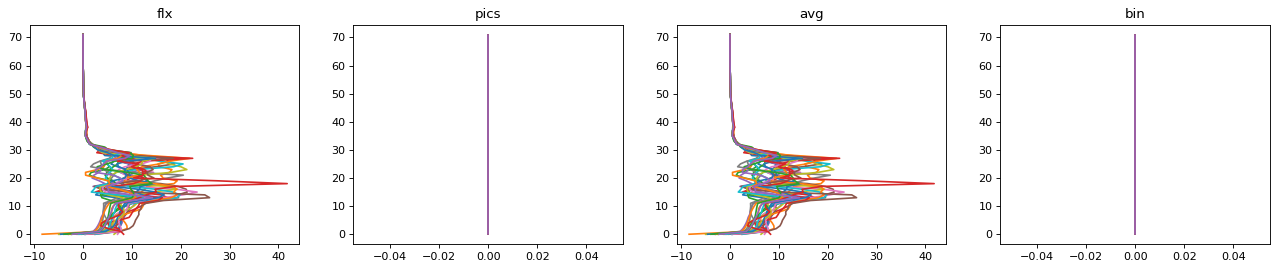

In [133]:
Plot_Batch(y[np.where(tn==1)[0]], ['flx', 'pics', 'avg', 'bin'] )

################################################

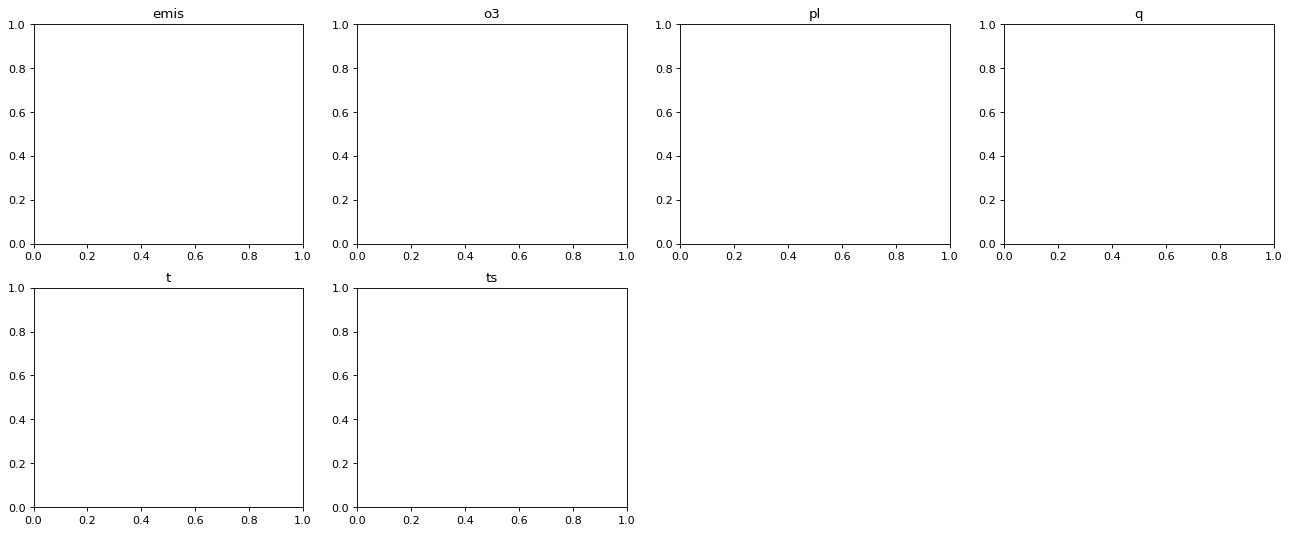

In [106]:
IDX = np.where(y_truth==1)[0]
Plot_Batch(x[IDX], header_x)

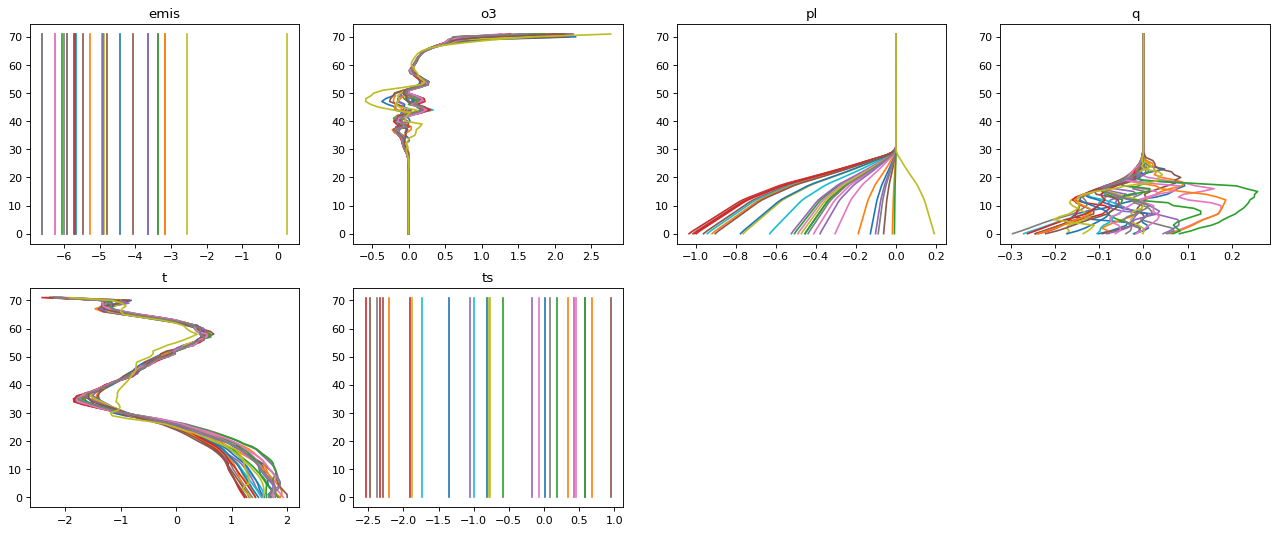

In [95]:
IDX = np.where(y_truth==0)[0]
Plot_Batch(x[IDX], header_x)

In [116]:
np.std(y[:,:,0], axis=1)

array([ 8.44018945,  4.8086794 ,  7.81805505,  4.78451419,  4.24440855,
        7.30109338, 12.67766289,  9.95846187,  7.13396902,  9.00866322,
        9.43741242,  6.06569297,  7.08384561,  8.57778901,  7.6794064 ,
        5.14821125,  4.51248874,  4.85900513, 16.06014101,  8.0483506 ,
        4.81822202,  4.28663988,  8.0639527 ,  9.23197598,  4.51892747,
        7.7692537 ,  7.24770188,  9.03920818,  8.00243785,  7.9839531 ,
        7.97237372,  7.46188809])

In [117]:
np.max(np.std(y[:,:,0], axis=1))

16.060141008741386

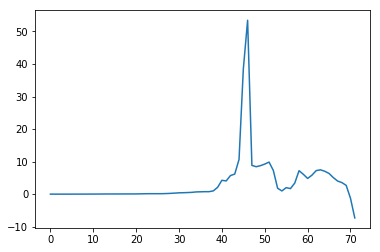

In [118]:
plt.plot(y[-4,:,0])